In [2]:
import pandas
import pm4py
from pm4py.objects.log.obj import EventLog, Trace
from nltk.cluster import KMeansClusterer
import nltk 
from sklearn import cluster
from sklearn import metrics
import time
import pandas as pd
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.preprocessing import Binarizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN



In [11]:
event_log = pandas.read_csv('logs/TJSP-BL-event-log.csv', sep=',')
#event_log = pandas.read_csv('TJSP.csv', sep=',')
#lawsuit_id,date,movement,order,status,area,subject_matter,control,digital,class,distribution_date,court_department,claim_amount,judge
event_log = pm4py.format_dataframe(event_log, case_id='lawsuit_id', activity_key='movement', timestamp_key='date')
event_log['date']=pd.to_datetime(event_log['date'], utc=True) # format the timestamp column

In [3]:
event_log.head()

lawsuit_id                      date  \
0  0000536-07.2020.8.26.0003 2020-01-04 00:00:00+00:00   
1  0000536-07.2020.8.26.0003 2020-01-06 00:00:00+00:00   
2  0000536-07.2020.8.26.0003 2020-01-06 00:00:00+00:00   
3  0000536-07.2020.8.26.0003 2020-01-06 00:00:00+00:00   
4  0000536-07.2020.8.26.0003 2020-01-22 00:00:00+00:00   

                        movement  order status   area subject_matter  \
0                        Decisão      0    NaN  Cível       Franquia   
1         Conclusos para Decisão      2    NaN  Cível       Franquia   
2        Conclusos para Despacho      1    NaN  Cível       Franquia   
3  Certidão de Cartório Expedida      0    NaN  Cível       Franquia   
4                        Decisão      2    NaN  Cível       Franquia   

       control     digital                     class  \
0  2020/000087  VERDADEIRO  Procedimento Comum Cível   
1  2020/000087  VERDADEIRO  Procedimento Comum Cível   
2  2020/000087  VERDADEIRO  Procedimento Comum Cível   
3  2020/000087  VERDADEIRO  Procedimento Comum Cível   
4  2020/000087  VERDADEIRO  Procedimento Comum Cível   

          distribution_date  \
0 2020-04-02 13:06:00+00:00   
1 2020-04-02 13:06:00+00:00   
2 2020-04-02 13:06:00+00:00   
3 2020-04-02 13:06:00+00:00   
4 2020-04-02 13:06:00+00:00   

                                    court_department claim_amount  \
0  2ª VARA EMPRESARIAL E CONFLITOS DE ARBITRAGEM ...    17.284,24   
1  2ª VARA EMPRESARIAL E CONFLITOS DE ARBITRAGEM ...    17.284,24   
2  2ª VARA EMPRESARIAL E CONFLITOS DE ARBITRAGEM ...    17.284,24   
3  2ª VARA EMPRESARIAL E CONFLITOS DE ARBITRAGEM ...    17.284,24   
4  2ª VARA EMPRESARIAL E CONFLITOS DE ARBITRAGEM ...    17.284,24   

                judge          case:concept:name  \
0  NBJH56504647452616  0000536-07.2020.8.26.0003   
1  NBJH56504647452616  0000536-07.2020.8.26.0003   
2  NBJH56504647452616  0000536-07.2020.8.26.0003   
3  NBJH56504647452616  0000536-07.2020.8.26.0003   
4  NBJH56504647452616  0000536-07.2020.8.26.0003   

                    concept:name            time:timestamp  @@index  \
0                        Decisão 2020-01-04 00:00:00+00:00        0   
1         Conclusos para Decisão 2020-01-06 00:00:00+00:00        1   
2        Conclusos para Despacho 2020-01-06 00:00:00+00:00        2   
3  Certidão de Cartório Expedida 2020-01-06 00:00:00+00:00        3   
4                        Decisão 2020-01-22 00:00:00+00:00        4   

   @@case_index  
0             0  
1             0  
2             0  
3             0  
4             0

In [44]:
def retrieve_traces(log):
    traces, ids = [], []
    for id in log["case:concept:name"].unique():
        events = list(log[log["case:concept:name"] == id]["concept:name"])
        traces.append(["".join(x) for x in events])
        ids.append(id)

    return ids, traces

def extract_corpus(log):
    traces, ids = [], []
    for id in log["case:concept:name"].unique():
        events = list(log[log["case:concept:name"] == id]["concept:name"])
        traces.append(" ".join(x.replace(" ", "") for x in events))
        ids.append(id)

    return ids, traces
    
def run_doc2vec_from_ft(vector_size, alpha, alpha_min, epochs, window, traces, tagged_traces):
    start_time = time.time()
  
    # build the model
    model = Doc2Vec(dm = 0, alpha=alpha, vector_size=vector_size, window=window, min_alpha=alpha_min, min_count=2, epochs=epochs)
    model.build_vocab(tagged_traces)
    model.train(tagged_traces, total_examples=model.corpus_count, epochs=model.epochs)

    vectors = [model.infer_vector(trace) for trace in traces]
    
    end_time = time.time() - start_time
    print(f"\nDoc2vec took {round(end_time, 2)} seconds")

    # saving
    encoded_df = pd.DataFrame(vectors, columns=[f'{i}' for i in range(vector_size)])
    return encoded_df


def create_cluster_kmeans(event_log, encoding, num_clusters):
    kmeans = cluster.KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(encoding[["0", "1"]])
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_

    silhouette_score = metrics.silhouette_score(encoding[["0", "1"]], labels, metric='euclidean')

    return encoding, silhouette_score


In [45]:
start_time = time.time()

ids, traces = retrieve_traces(event_log)
tagged_traces = [TaggedDocument(words=act, tags=[str(i)]) for i, act in enumerate(traces)]

experiment = []
for vector_size in range(2, 8):
    for alpha in [ 0.001, 0.005, 0.01, 0.025 ]:
        for alpha_min in [ 0.001, 0.005, 0.01, 0.025 ]:
            for epochs in [ 5, 10, 20, 30 ]:
                    for window in [3, 5, 7, 10]:
                        encoding1 = run_doc2vec_from_ft(vector_size, alpha, alpha_min, epochs, window, traces, tagged_traces)
                        for k in range(2, 8):
                            encoding1, silhouette_score = create_cluster_kmeans(event_log, encoding1, k)
                            experiment.append([k, vector_size, alpha, alpha_min, epochs, window, silhouette_score])
        
experiment_df = pd.DataFrame(experiment, columns=['k','vector_size', 'alpha','alpha_min','epochs', 'window','silhouette_score'])
end_time = time.time() - start_time
print(f"\nExperiments took {round(end_time, 2)} seconds")




Doc2vec took 0.64 seconds

Doc2vec took 0.71 seconds

Doc2vec took 0.71 seconds

Doc2vec took 0.72 seconds

Doc2vec took 1.28 seconds

Doc2vec took 1.28 seconds

Doc2vec took 1.29 seconds

Doc2vec took 1.28 seconds

Doc2vec took 2.38 seconds

Doc2vec took 2.4 seconds

Doc2vec took 2.39 seconds

Doc2vec took 2.39 seconds

Doc2vec took 3.51 seconds

Doc2vec took 3.51 seconds

Doc2vec took 3.53 seconds

Doc2vec took 3.5 seconds

Doc2vec took 0.75 seconds

Doc2vec took 0.72 seconds

Doc2vec took 0.73 seconds

Doc2vec took 0.73 seconds

Doc2vec took 1.3 seconds

Doc2vec took 1.29 seconds

Doc2vec took 1.29 seconds

Doc2vec took 1.34 seconds

Doc2vec took 2.46 seconds

Doc2vec took 2.47 seconds

Doc2vec took 2.44 seconds

Doc2vec took 2.45 seconds

Doc2vec took 3.57 seconds

Doc2vec took 3.6 seconds

Doc2vec took 3.57 seconds

Doc2vec took 3.59 seconds

Doc2vec took 0.73 seconds

Doc2vec took 0.73 seconds

Doc2vec took 0.73 seconds

Doc2vec took 0.73 seconds

Doc2vec took 1.31 seconds

Doc2

In [46]:
experiment_df

k  vector_size  alpha  alpha_min  epochs  window  silhouette_score
0     2            2  0.001      0.001       5       3          0.356029
1     3            2  0.001      0.001       5       3          0.385452
2     4            2  0.001      0.001       5       3          0.402069
3     5            2  0.001      0.001       5       3          0.377815
4     6            2  0.001      0.001       5       3          0.354554
...  ..          ...    ...        ...     ...     ...               ...
9211  3            7  0.025      0.025      30      10          0.360553
9212  4            7  0.025      0.025      30      10          0.345774
9213  5            7  0.025      0.025      30      10          0.335545
9214  6            7  0.025      0.025      30      10          0.332497
9215  7            7  0.025      0.025      30      10          0.330694

[9216 rows x 7 columns]

In [47]:
#experiment_df.to_csv('results/experiment_1.csv', index=False)

In [12]:
experiment_df = pd.read_csv("results/experiment_1.csv")

In [4]:
experiment_df.head()

k  vector_size  alpha  alpha_min  epochs  window  silhouette_score
0  2            2  0.001      0.001       5       3          0.356029
1  3            2  0.001      0.001       5       3          0.385452
2  4            2  0.001      0.001       5       3          0.402069
3  5            2  0.001      0.001       5       3          0.377815
4  6            2  0.001      0.001       5       3          0.354554

In [5]:
experiment_df.sort_values(['silhouette_score'], ascending=[False]).style.background_gradient()


In [6]:
corr = experiment_df.corr()
corr.style.background_gradient(cmap='coolwarm')

<Axes: title={'center': 'silhouette_score'}, xlabel='epochs'>

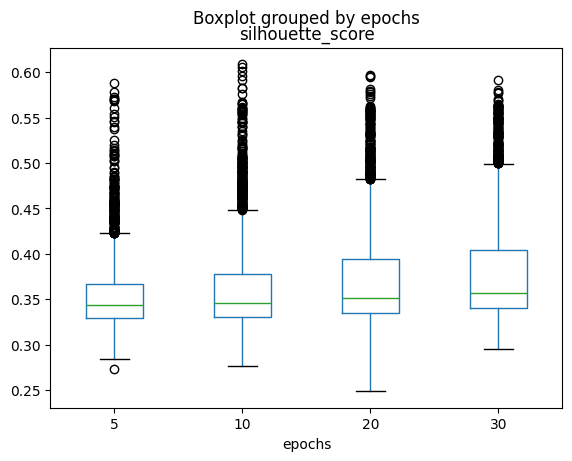

In [51]:
experiment_df.boxplot(by ='epochs', column =['silhouette_score'], grid = False) 

<Axes: title={'center': 'silhouette_score'}, xlabel='k'>

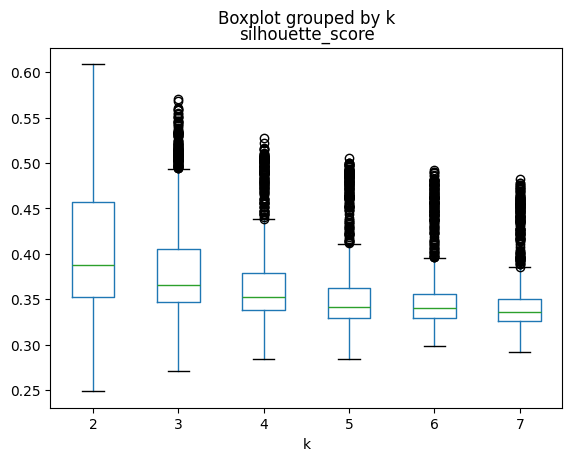

In [52]:
experiment_df.boxplot(by ='k', column =['silhouette_score'], grid = False) 

<Axes: title={'center': 'silhouette_score'}, xlabel='window'>

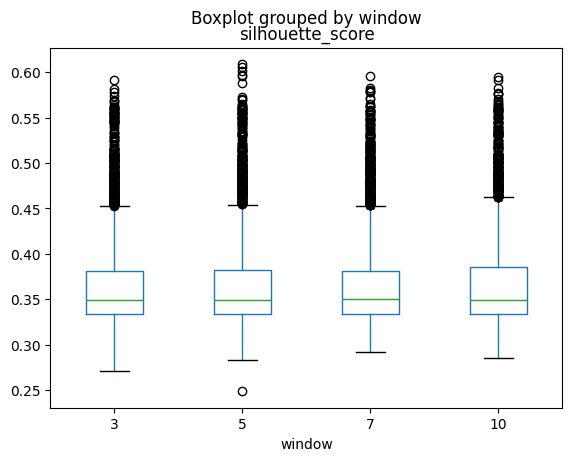

In [53]:
experiment_df.boxplot(by ='window', column =['silhouette_score'], grid = False) 

<Axes: title={'center': 'silhouette_score'}, xlabel='alpha'>

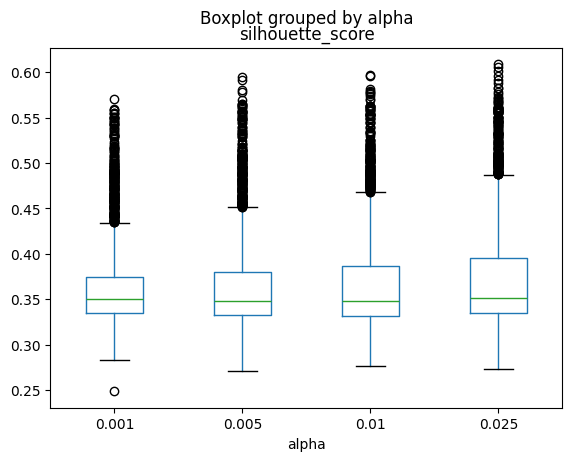

In [54]:
experiment_df.boxplot(by ='alpha', column =['silhouette_score'], grid = False) 

<Axes: title={'center': 'silhouette_score'}, xlabel='window'>

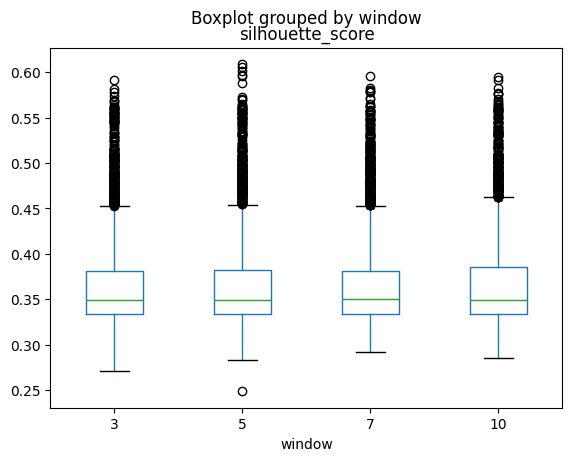

In [10]:
experiment_df.boxplot(by ='window', column =['silhouette_score'], grid = False) 

<Axes: title={'center': 'silhouette_score'}, xlabel='alpha_min'>

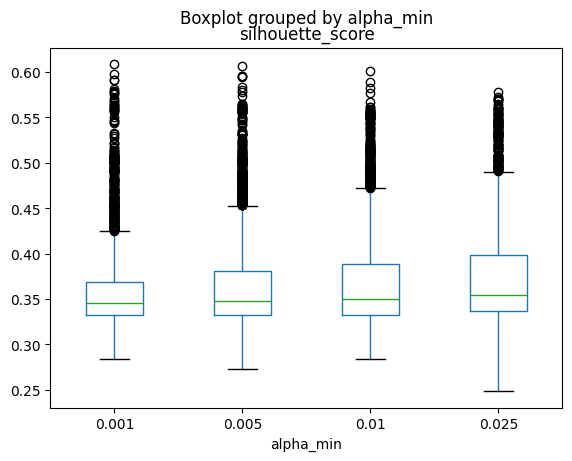

In [7]:
experiment_df.boxplot(by ='alpha_min', column =['silhouette_score'], grid = False) 

In [9]:
experiment_df[['silhouette_score']].describe()

silhouette_score
count       9216.000000
mean           0.369092
std            0.055417
min            0.248468
25%            0.333305
50%            0.349364
75%            0.382441
max            0.608946